[![Open in Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/astroML/astroML-notebooks/main?filepath=chapter10/wavelets.ipynb)

## Wavelets
An increasingly popular family of basis functions is called **wavelets**. By construction, wavelets are localized in both frequency and time domains. Individual wavelets are specified by a set of wavelet filter coefficients. Given a wavelet, a complete
orthonormal set of basis functions can be constructed by scalings and translations. Different wavelet families trade the localization of a wavelet with its smoothness.

### Wavelet transform of Gaussian Noise
Below we have an example using a particular wavelet to compute a wavelet PSD as a
function of time $t_0$ and frequency $f_0$. The wavelet used is of the form

$$w(t|t_0,f_0,Q) = A exp[i2\pi f_0 (t-t_0)]exp[-f_0^2(t-t_0)^2/Q^2]$$

where $t_0$ is the central time, $f_0$ is the central frequency, and the dimensionless parameter Q is
a model parameter which controls the width of the frequency window.  
The Fourier transform of this form is 

$$W(f|t_0,f_0,Q)=(\frac{\pi}{f^2_0/Q^2})^{1/2} exp(-i2\pi f t_0) exp[\frac{-\pi^2Q^2(f-f_0)^2}{Qf^2_0}]$$
  
Note that the form given by above equations is not technically a wavelet because it
does not meet the admissibility criterion (the equivalent of orthogonality in Fourier transforms).
This form is closely related to a true wavelet, the *Morlet wavelet*, through a simple scaling and offset. Therefore, these equations should probaly be referred to as "matched filters" rather than "wavelets".  
However, these functions display quite nicely one
main property of wavelets: the localization of power in both time and frequency. For this reason,
we will refer to these functions as "wavelets," and explore their ability to localize frequency signals.

#### Imput signal
We take a localized Gaussian noise as imput signal, as shown below.

In [22]:
import numpy as np
from matplotlib import pyplot as plt

from astroML.fourier import sinegauss, wavelet_PSD, FT_continuous, IFT_continuous

from astroML.plotting import setup_text_plots
setup_text_plots(usetex=True)

Text(0, 0.5, '$h(t)$')

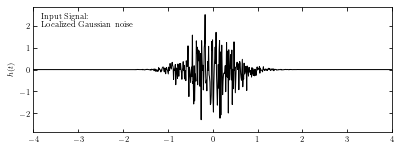

In [14]:
# Sample the function: localized noise
np.random.seed(0)

N = 1024
t = np.linspace(-5, 5, N)
x = np.ones(len(t))

h = np.random.normal(0, 1, len(t))
h *= np.exp(-0.5 * (t / 0.5) ** 2)

# Show signal
fig = plt.figure(figsize=(6, 2))
fig.subplots_adjust(hspace=0.05, left=0.12, right=0.95, bottom=0.08, top=0.95)

ax = fig.add_subplot(111)
ax.plot(t, h, '-k', lw=1)
ax.text(0.02, 0.95, ("Input Signal:\n"
                     "Localized Gaussian noise"),
        ha='left', va='top', transform=ax.transAxes)

ax.set_xlim(-4, 4)
ax.set_ylim(-2.9, 2.9)
ax.set_ylabel('$h(t)$')

#### Compute wavelet
We compute the wavelet from sample data using *sinegauss* function in *astroML.fourier*.  
Here we take Q=1.0 to control the width of the frequency window. 
In the plot, solid line and dashed line show the real part and imaginary part respectively.

Text(0, 0.5, '$w(t; t_0, f_0, Q)$')

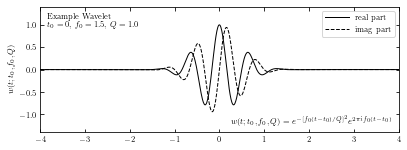

In [15]:
# Compute an example wavelet
W = sinegauss(t, 0, 1.5, Q=1.0)

# Show the example wavelet
fig = plt.figure(figsize=(6, 2))
fig.subplots_adjust(hspace=0.05, left=0.12, right=0.95, bottom=0.08, top=0.95)

ax = fig.add_subplot(111)
ax.plot(t, W.real, '-k', label='real part', lw=1)
ax.plot(t, W.imag, '--k', label='imag part', lw=1)

ax.text(0.02, 0.95, ("Example Wavelet\n"
                     "$t_0 = 0$, $f_0=1.5$, $Q=1.0$"),
        ha='left', va='top', transform=ax.transAxes)
ax.text(0.98, 0.05,
        (r"$w(t; t_0, f_0, Q) = e^{-[f_0 (t - t_0) / Q]^2}"
         "e^{2 \pi i f_0 (t - t_0)}$"),
        ha='right', va='bottom', transform=ax.transAxes)

ax.legend(loc=1)

ax.set_xlim(-4, 4)
ax.set_ylim(-1.4, 1.4)
ax.set_ylabel('$w(t; t_0, f_0, Q)$')

#### Compute PSD
The wavelet PSD (power spectral density) is defined by $PSD_w(f0, t0;Q) = |Hw(t_0; f_0,Q)|^2$. Unlike
the typical Fourier-transform PSD, the wavelet PSD allows detection of frequency information
which is localized in time.  
Here we compute the wavelet PSD from sample wavelet using *wavelet_PSD* function in *astroML.fourier*. 
  
The plot shows the PSD as a function of the frequency $f_0$ and the time $t_0$, for Q = 1.0.

Text(0, 0.5, '$f_0$')

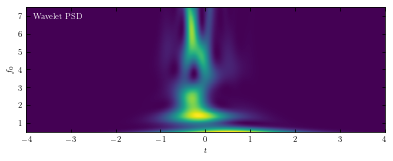

In [16]:
# Compute the wavelet PSD
f0 = np.linspace(0.5, 7.5, 100)
wPSD = wavelet_PSD(t, h, f0, Q=1.0)

# Plot the results
fig = plt.figure(figsize=(6, 2))
fig.subplots_adjust(hspace=0.05, left=0.12, right=0.95, bottom=0.08, top=0.95)

# Third panel: the spectrogram
ax = plt.subplot(111)
ax.imshow(wPSD, origin='lower', aspect='auto',
          extent=[t[0], t[-1], f0[0], f0[-1]])

ax.text(0.02, 0.95, ("Wavelet PSD"), color='w',
        ha='left', va='top', transform=ax.transAxes)

ax.set_xlim(-4, 4)
ax.set_ylim(0.5, 7.5)

ax.set_xlabel('$t$')
ax.set_ylabel('$f_0$')

### Wavelet transform of a Noisy Spike
Here we use wavelet transform when the imput data is noisy spike rather than local Gaussian. 

#### Define functions and construct imput noise
This example uses a Gaussian spike in the presence of white (Gaussian) noise as the imput noise. The imput signal is shown below.

Text(0, 0.5, '$h(t)$')

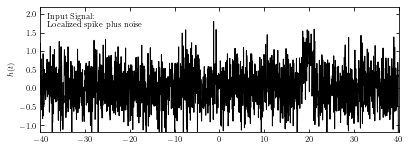

In [17]:
def wavelet(t, t0, f0, Q):
    return (np.exp(-(f0 / Q * (t - t0)) ** 2)
            * np.exp(2j * np.pi * f0 * (t - t0)))

def wavelet_FT(f, t0, f0, Q):
    # this is its fourier transform using
    # H(f) = integral[ h(t) exp(-2pi i f t) dt]
    return (np.sqrt(np.pi) * Q / f0
            * np.exp(-2j * np.pi * f * t0)
            * np.exp(-(np.pi * (f - f0) * Q / f0) ** 2))

def check_funcs(t0=1, f0=2, Q=3):
    t = np.linspace(-5, 5, 10000)
    h = wavelet(t, t0, f0, Q)

    f, H = FT_continuous(t, h)
    assert np.allclose(H, wavelet_FT(f, t0, f0, Q))

    
# Create the simulated dataset
np.random.seed(5)

t = np.linspace(-40, 40, 2001)[:-1]
h = np.exp(-0.5 * ((t - 20.) / 1.0) ** 2)
hN = h + np.random.normal(0, 0.5, size=h.shape)

# Plot the results
fig = plt.figure(figsize=(6, 2))
fig.subplots_adjust(hspace=0.05, left=0.12, right=0.95, bottom=0.08, top=0.95)

# plot the signal
ax = fig.add_subplot(111)
ax.plot(t, hN, '-k', lw=1)

ax.text(0.02, 0.95, ("Input Signal:\n"
                     "Localized spike plus noise"),
        ha='left', va='top', transform=ax.transAxes)

ax.set_xlim(-40, 40)
ax.set_ylim(-1.2, 2.2)
ax.set_ylabel('$h(t)$')

#### Compute wavelet
Compute the convolution via the continuous Fourier transform. This is more exact than using the discrete transform, because we have an analytic expression for the FT of the wavelet. The wavelet transform applied to data h(t) is given by

$$H_w(t_0;f_0,Q)=\int^{\infty}_{\infty} h(t)w(t|t_0,f_0,Q)dt$$

By the convolution theorem $H(f) = A(f)B(f)$, we can write the Fourier transform
of $H_w$ as the pointwise product of the Fourier transforms of h(t) and $w*(t; t_0; f_0, Q)$. The first can
be approximated using the discrete Fourier transform as shown in appendix E in the textbook; the second can be found using the analytic formula for W(f) in the prevoius section. This allows us to quickly evaluate $H_w$ as a
function of $t_0$ and $f_0$, using two $O(N logN)$ fast Fourier transforms.

Text(0, 0.5, '$w(t; t_0, f_0, Q)$')

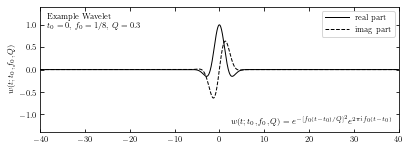

In [23]:
Q = 0.3
f0 = 2 ** np.linspace(-3, -1, 100)

f, H = FT_continuous(t, hN)

# Plot the results
fig = plt.figure(figsize=(6, 2))
fig.subplots_adjust(hspace=0.05, left=0.12, right=0.95, bottom=0.08, top=0.95)

# plot the wavelet
ax = fig.add_subplot(111)
W = wavelet(t, 0, 0.125, Q)
ax.plot(t, W.real, '-k', label='real part', lw=1)
ax.plot(t, W.imag, '--k', label='imag part', lw=1)

ax.legend(loc=1)
ax.text(0.02, 0.95, ("Example Wavelet\n"
                     "$t_0 = 0$, $f_0=1/8$, $Q=0.3$"),
        ha='left', va='top', transform=ax.transAxes)
ax.text(0.98, 0.05,
        (r"$w(t; t_0, f_0, Q) = e^{-[f_0 (t - t_0) / Q]^2}"
         "e^{2 \pi i f_0 (t - t_0)}$"),
        ha='right', va='bottom', transform=ax.transAxes)

ax.set_xlim(-40, 40)
ax.set_ylim(-1.4, 1.4)
ax.set_ylabel('$w(t; t_0, f_0, Q)$')

#### Compute spectrogram
We compute spectrogram using *IFT_continuous* in *astroML.fourier*.  
The plot below shows the power spectral density as a function of the frequency $f_0$ and the time $t_0$, for Q = 0.3.

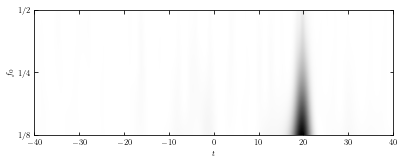

In [24]:
W = np.conj(wavelet_FT(f, 0, f0[:, None], Q))
t, HW = IFT_continuous(f, H * W)

# Plot the results
fig = plt.figure(figsize=(6, 2))
fig.subplots_adjust(hspace=0.05, left=0.12, right=0.95, bottom=0.08, top=0.95)

# plot the spectrogram
ax = fig.add_subplot(111)
ax.imshow(abs(HW) ** 2, origin='lower', aspect='auto', cmap=plt.cm.binary,
          extent=[t[0], t[-1], np.log2(f0)[0], np.log2(f0)[-1]])
ax.set_xlim(-40, 40)

ax.text(0.02, 0.95, ("Wavelet PSD"), color='w',
        ha='left', va='top', transform=ax.transAxes)

ax.set_ylim(np.log2(f0)[0], np.log2(f0)[-1])
ax.set_xlabel('$t$')
ax.set_ylabel('$f_0$')

ax.yaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, *args: ("1/%i"
                                                                 % (2 ** -x))))

### Examples of Wavelets
The resulting wavelets vary from different parameters Q and $f_0$. 
Here we take several different parameters Q and $f_0$ and show the result wavelets, taking the prevoius Gaussian sample imput. 

In [25]:
# Set up the wavelets
t0 = 0
t = np.linspace(-0.4, 0.4, 10000)
f0 = np.array([5, 5, 10, 10])
Q = np.array([1, 0.5, 1, 0.5])

# compute wavelets all at once
W = sinegauss(t, t0, f0[:, None], Q[:, None])


Solid lines show the real part and dashed lines show the imaginary part.

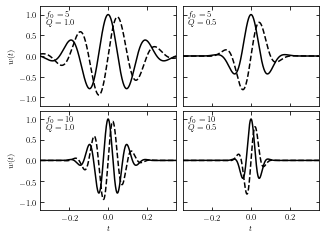

In [26]:
# Plot the wavelets
fig = plt.figure(figsize=(5, 3.75))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# in each panel, plot and label a different wavelet
for i in range(4):
    ax = fig.add_subplot(221 + i)
    ax.plot(t, W[i].real, '-k')
    ax.plot(t, W[i].imag, '--k')

    ax.text(0.04, 0.95, "$f_0 = %i$\n$Q = %.1f$" % (f0[i], Q[i]),
            ha='left', va='top', transform=ax.transAxes)

    ax.set_ylim(-1.2, 1.2)
    ax.set_xlim(-0.35, 0.35)

    ax.xaxis.set_major_locator(plt.MultipleLocator(0.2))

    if i in (0, 1):
        ax.xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax.set_xlabel('$t$')

    if i in (1, 3):
        ax.yaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax.set_ylabel('$w(t)$')